In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def import_data(detector:str, mass_ratio):
    """Import data computed from scr/rayleigh_criterion_two_modes.py
    
    Parameters
    ----------
    detector : str
        Gravitational wave detector name. Must be {'LIGO', 'LISA',
        'CE' = 'CE2silicon', 'CE2silica', 'ET'}.
    mass_ratio : TYPE
        Binary black hole mass ratio. mass_ratio >= 1. This is used to
        determine the QNM parameters.
    
    Returns
    -------
    Pandas DataFrame
        Return DataFrame with the data
    """
    columns = ('mass',
               'redshift',
               'mode_0',
               'mode_1',
               'delta_freq',
               'sigma_freq_0',
               'sigma_freq_1',
               'delta_tau',
               'sigma_tau_0',
               'sigma_tau_1',
               'snr_0',
               'snr_1',
              )

    df = pd.read_csv(f'../data/LIGO/{detector}_q_{mass_ratio}_rayleigh_criterion.dat', delimiter = "\t", comment="#", names=columns)
    df['mass_ratio'] = [mass_ratio]*len(df.mass)
    
    return df

def compute_criterion(data_frame):
    """Compute Rayleigh Criterion and SNR > 8 criterion.
    
    Parameters
    ----------
    data_frame : Pandas DataFrame
        DataFrame imported using 'import_data' function.
    """
    f_factor_1 = 4
    f_factor_2 = 0#.6
    tau_factor_1 = 10
    tau_factor_2 = 0#0.000005
    # compute rayleigh criterion
    data_frame['sigma_freq'] = data_frame.apply(lambda row: max(row.sigma_freq_0, row.sigma_freq_1), axis=1)
    data_frame['ray_freq'] = data_frame.apply(lambda row: np.sign(f_factor_1*row.delta_freq + f_factor_2/row.delta_freq - row.sigma_freq)+1, axis=1)

    data_frame['sigma_tau'] = data_frame.apply(lambda row: max(row.sigma_tau_0, row.sigma_tau_1), axis=1)
    data_frame['ray_tau'] = data_frame.apply(lambda row: np.sign(tau_factor_1*row.delta_tau + tau_factor_2/row.delta_tau - row.sigma_tau)+1, axis=1)

    data_frame['rayleigh'] = data_frame.apply(lambda row: np.sign(row.ray_freq and row.ray_tau), axis=1)

    # compute SNR > 8
    data_frame['snr_c_0'] = data_frame.apply(lambda row: np.sign(row.snr_0 - 8)+1, axis=1)
    data_frame['snr_c_1'] = data_frame.apply(lambda row: np.sign(row.snr_1 - 8)+1, axis=1)
    data_frame['snr'] = data_frame.apply(lambda row: np.sign(row.snr_c_0 and row.snr_c_1), axis=1)

    # both conditions
    data_frame['both'] = data_frame.apply(lambda row: np.sign(row.rayleigh and row.snr), axis=1)
    

In [3]:
def find_horizon_contour(data_frame, modes:tuple):
    """Compute horizon contour
    
    Parameters
    ----------
    data_frame : Pandas DataFrame
        Description
    modes : tuple
        2d tuple containig mode_0 and mode_1
    
    Returns
    -------
    list, list
        Returns masses and redshifts at the horizon arrays
    """
    pair = (data_frame.mode_0 == modes[0])&(data_frame.mode_1 == modes[1])&(data_frame.ray_freq==1)
    df_pair = data_frame[pair]
    X = df_pair.mass
    Y = df_pair.redshift
    Z = df_pair.both
    masses = sorted(set(X))
    redshifts = [max(Y[X==mass]) for mass in masses]
    if len(redshifts) > 0:
        redshifts[0] = min(Y[X==masses[0]]) 
        redshifts[-1] = min(Y[X==masses[-1]]) 
    
    return masses, redshifts

In [4]:
# df = import_data('LIGO', 1.5)
# compute_criterion(df)

In [5]:
# modes = ['(2,2,0)', '(2,2,1) II', '(3,3,0)', '(4,4,0)', '(2,1,0)']
# horizons = pd.DataFrame()
# for comb in list(combinations(modes, 2)):
#     extra = {}
#     extra['masses'],  extra['redshifts'] = find_horizon_contour(df, comb)
#     extra['modes'] = [comb]*len(extra['masses'])
#     horizons = horizons.append(pd.DataFrame(extra))


In [6]:
# two_modes = []
# for mode in modes[1:]:
#     two_modes.append(('(2,2,0)',mode))

# colors = {
#     '(2,2,1) II': 'tab:red',
#     '(3,3,0)': 'tab:green',
#     '(4,4,0)': 'tab:blue',
#     '(2,1,0)': 'tab:orange',
# }
# for comb in two_modes:
#     df_plot = horizons[horizons.modes == comb]
#     plt.loglog(df_plot.masses, df_plot.redshifts, color = colors[comb[1]]);

# plt.ylim(1e-2,10)
# plt.show()
    

In [4]:
def plot_220_2modes(data_frame):
    modes = ['(2,2,1) II', '(3,3,0)', '(4,4,0)', '(2,1,0)']
    two_modes = [('(2,2,0)',mode) for mode in modes]

    horizons = pd.DataFrame()
    for comb in two_modes:
        extra = {}
        extra['masses'],  extra['redshifts'] = find_horizon_contour(data_frame, comb)
        if len(extra['masses']) == 0:
            extra['masses'],  extra['redshifts'] = [np.nan]*2, [np.nan]*2
        extra['modes'] = [comb]*len(extra['masses'])
        horizons = horizons.append(pd.DataFrame(extra))

    colors = {
        '(2,2,1) II': 'tab:red',
        '(3,3,0)': 'tab:green',
        '(4,4,0)': 'tab:blue',
        '(2,1,0)': 'tab:orange',
    }
    for comb in two_modes:
        df_plot = horizons[horizons.modes == comb]
        plt.loglog(df_plot.masses, df_plot.redshifts, color = colors[comb[1]]);


In [5]:
# import all data
detectors = ["LIGO"]#, "ET", "CE", "LISA"]
ray = pd.DataFrame()

for q in [1.5, 10]:
    for detector in detectors:
        ray = ray.append(import_data(detector, q))
compute_criterion(ray)



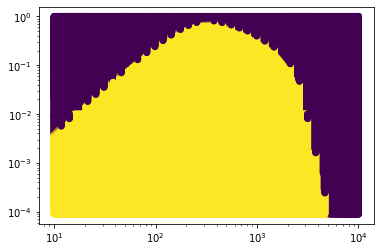

In [17]:
df_plot = ray[(ray.mode_0 == '(2,2,0)')&(ray.mode_1 == '(2,2,1) II')]
df_plot

plt.scatter(df_plot.mass, df_plot.redshift, c = df_plot.ray_tau)
plt.xscale('log')
plt.yscale('log')

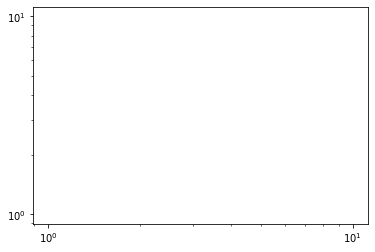

In [6]:
# plot all data
for detector in detectors:
    plot_220_2modes(ray)

In [10]:
def import_data_bayes(mass_ratio, mode):
    """Import data computed from scr/rayleigh_criterion_two_modes.py
    
    Parameters
    ----------
    detector : str
        Gravitational wave detector name. Must be {'LIGO', 'LISA',
        'CE' = 'CE2silicon', 'CE2silica', 'ET'}.
    mass_ratio : TYPE
        Binary black hole mass ratio. mass_ratio >= 1. This is used to
        determine the QNM parameters.
    
    Returns
    -------
    Pandas DataFrame
        Return DataFrame with the data
    """
    columns = ('mass',
               'redshift',
              )

    df = pd.read_csv(f'../data/bayes/horizon_{mass_ratio}_data_220_{mode}_model_220.dat', delimiter = "\t", comment="#", names=columns)
    df['modes'] = [mode]*len(df.mass)
    df['mass_ratio'] = [mass_ratio]*len(df.mass)
    return df

In [11]:
bayes = pd.DataFrame()
for q in [1.5, 10]:
    for mode in ['221', '330', '440', '210']:
        bayes = bayes.append(import_data_bayes(q, mode))

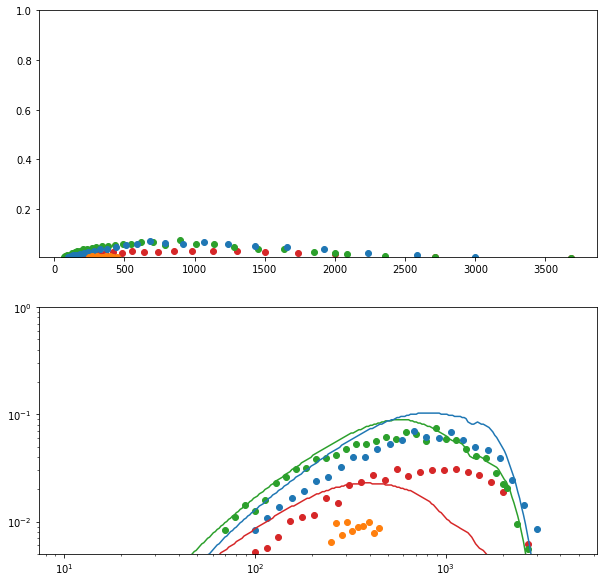

In [14]:
fig, ax = plt.subplots(2, figsize = [10,10])
i = 0

colors = {
    '221': 'tab:red',
    '330': 'tab:green',
    '440': 'tab:blue',
    '210': 'tab:orange',
}
plot_220_2modes(ray[ray['mass_ratio']==10])
for q in bayes.mass_ratio.unique():
    df_q_bayes = bayes[bayes.mass_ratio == 10]
    for mode in bayes.modes.unique():
        df_plot_bayes = df_q_bayes[df_q_bayes.modes == mode]
        ax[i].scatter(df_plot_bayes.mass, df_plot_bayes.redshift, label = mode, color = colors[mode])
    ax[i].set_ylim(5e-3, 1)
    print('')
        
    i += 1

In [13]:
ray

,mass,redshift,mode_0,mode_1,delta_freq,sigma_freq_0,sigma_freq_1,delta_tau,sigma_tau_0,sigma_tau_1,...,mass_ratio,sigma_freq,ray_freq,sigma_tau,ray_tau,rayleigh,snr_c_0,snr_c_1,snr,both
0,10.000000,0.008913,"(2,2,0)","(2,2,1) II",40.008857,314.660561,2660.579899,0.000406,0.001921,0.001531,...,1.5,2660.579899,0.0,0.001921,2.0,0.0,0.0,0.0,0.0,0.0
1,12.030053,0.043672,"(2,2,0)","(2,2,1) II",32.149791,753.633697,6379.209427,0.000505,0.007301,0.006073,...,1.5,6379.209427,0.0,0.007301,0.0,0.0,0.0,0.0,0.0,0.0
2,14.472219,0.213994,"(2,2,0)","(2,2,1) II",22.975127,1352.627275,11490.327672,0.000706,0.026775,0.023792,...,1.5,11490.327672,0.0,0.026775,0.0,0.0,0.0,0.0,0.0,0.0
3,17.817063,0.009126,"(2,2,0)","(2,2,1) II",22.450600,46.836132,397.989273,0.000723,0.000974,0.000869,...,1.5,397.989273,0.0,0.000974,2.0,0.0,2.0,0.0,0.0,0.0
4,21.434022,0.044720,"(2,2,0)","(2,2,1) II",18.026277,117.151273,999.508870,0.000900,0.003886,0.003603,...,1.5,999.508870,0.0,0.003886,2.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,10000.000000,0.009095,"(4,4,0)","(2,1,0)",1.601771,2678.649053,881.056465,0.029949,13365.388877,41204.916576,...,10.0,2678.649053,0.0,41204.916576,0.0,0.0,0.0,2.0,0.0,0.0
1199996,10000.000000,0.009313,"(4,4,0)","(2,1,0)",1.601424,2748.190577,903.536957,0.029956,13720.430908,42275.847365,...,10.0,2748.190577,0.0,42275.847365,0.0,0.0,0.0,2.0,0.0,0.0
1199997,10000.000000,0.009537,"(4,4,0)","(2,1,0)",1.601070,2819.893112,926.727580,0.029963,14086.956315,43382.385574,...,10.0,2819.893112,0.0,43382.385574,0.0,0.0,0.0,2.0,0.0,0.0
1199998,10000.000000,0.009766,"(4,4,0)","(2,1,0)",1.600707,2893.524308,950.518243,0.029969,14463.750138,44518.686272,...,10.0,2893.524308,0.0,44518.686272,0.0,0.0,0.0,2.0,0.0,0.0
